[![Open In Colab](https://img.shields.io/static/v1?message=Open%20in%20Colab&logo=googlecolab&label=%20&labelColor=5c5c5c&color=23c7a2&style=flat-square)](https://colab.research.google.com/github/einbandi/paradime/blob/master/notebooks/mds.ipynb)

In [1]:
import sys
sys.path.append("../")

# Linear Parametric MDS

In this short example we will learn how to implement a simple parametric version of MDS using the paraDime API. We will also verify that learning a linear transformation with the MDS loss and euclidean distances leads to the same transformation matrix as the one for PCA.

We start by importing some packages and all the relevant paraDime submodules.

In [2]:
import numpy as np
import torch
import sklearn.datasets
import sklearn.decomposition
from matplotlib import pyplot as plt

import paradime.dr
import paradime.relations
import paradime.transforms
import paradime.loss
import paradime.utils

paradime.utils.seed.seed_all(42);

As a toy dataset for this example, we use the diabetes data from sklearn. It consists of 442 datapoints with 10 features that can be used to predict a quantitative measure of disease progression.

In [3]:
diabetes = sklearn.datasets.load_diabetes()
data = diabetes['data']

Let's first perform PCA on the dataset:

In [4]:
pca = sklearn.decomposition.PCA().fit(data)

Before we train an MDS routine, let's first verify that paraDime is working as intended. To do this, we'll check what happens when we attempt to learn a linear transformation that approximates the PCA-transformed data directly using a [PositionLoss](../api/modules.rst#paradime.loss.PositionLoss):

In [5]:
pd_pca = paradime.dr.ParametricDR(
    model=torch.nn.Linear(10,10,bias=False),
    verbose=True,
)
pd_pca.register_dataset({
    "data": data,
    "pca": pca.transform(data),
})
pd_pca.add_training_phase(
    epochs=20,
    batch_size=50,
    loss=paradime.loss.PositionLoss(
        position_key="pca",
        embedding_method="forward",
    ),
    report_interval=2,
)
pd_pca.train()

2022-09-08 12:51:28,101: Registering dataset.
2022-09-08 12:51:28,111: Beginning training phase 'None'.
2022-09-08 12:51:28,305: Loss after epoch 0: 0.01773743494413793
2022-09-08 12:51:28,323: Loss after epoch 2: 0.006515668239444494
2022-09-08 12:51:28,338: Loss after epoch 4: 0.0027095351833850145
2022-09-08 12:51:28,353: Loss after epoch 6: 0.0012391704076435417
2022-09-08 12:51:28,373: Loss after epoch 8: 0.0006386753848346416
2022-09-08 12:51:28,391: Loss after epoch 10: 0.00034156230321968906
2022-09-08 12:51:28,406: Loss after epoch 12: 0.0001973757216546801
2022-09-08 12:51:28,421: Loss after epoch 14: 0.00012344656124696485
2022-09-08 12:51:28,437: Loss after epoch 16: 8.501370757585391e-05
2022-09-08 12:51:28,453: Loss after epoch 18: 6.296440506048384e-05


Let's compare the true PCA tranformation matrix and the one approximated via the [PositionLoss](../api/modules.rst#paradime.loss.PositionLoss):

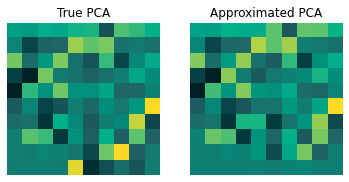

In [6]:
cmap = paradime.utils.plotting.get_colormap()
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(pca.components_, cmap=cmap)
ax1.set_axis_off()
ax1.set_title("True PCA")
ax2.imshow(pd_pca.model.weight.detach().numpy(), cmap=cmap)
ax2.set_axis_off()
ax2.set_title("Approximated PCA");

As expected, the matrices look very similar. Bigger differences are only visible in the bottom two rows. This makes sense, because these rows correspond to the "least important" components. Getting them wrong affects the overall positions of the tranformed data the least.

Now that we've confirmed that paraDime works correctly in this case, let's move to MDS. The loss used in MDS leads to transformed points that ideally have very similar pairwise distances as the orignal points. We implement this loss with simple pairwise distances as both global and batch-wise relations (the batch ones just have to be differentiable). We compare the two distance matrices in a [RelationLoss](../api/modules.rst#paradime.loss.RelationLoss) using a simple mean square error loss:

In [7]:
def mse(a, b):
    return torch.sum((a - b) ** 2)


pd_mds = paradime.dr.ParametricDR(
    model=torch.nn.Linear(10, 2, bias=False),
    global_relations=paradime.relations.PDist(
        transform=[
            paradime.transforms.ToSquareTensor(),
            paradime.transforms.Functional(lambda x: x.float()),
        ]
    ),
    batch_relations=paradime.relations.DifferentiablePDist(
        transform=paradime.transforms.ToSquareTensor()
    ),
    verbose=True,
)
pd_mds.register_dataset(
    {
        "data": data,
    }
)
pd_mds.add_training_phase(
    epochs=500,
    batch_size=len(data),
    learning_rate=0.01,
    loss=paradime.loss.RelationLoss(
        loss_function=mse,
        embedding_method="forward",
        normalize_sub=False,
    ),
    report_interval=50,
)
pd_mds.train()


2022-09-08 12:51:28,746: Registering dataset.
2022-09-08 12:51:28,748: Computing global relations 'rel'.
2022-09-08 12:51:28,749: Calculating pairwise distances.
2022-09-08 12:51:28,755: Beginning training phase 'None'.
2022-09-08 12:51:28,795: Loss after epoch 0: 6230.341796875
2022-09-08 12:51:29,828: Loss after epoch 50: 1157.6181640625
2022-09-08 12:51:30,811: Loss after epoch 100: 702.5980224609375
2022-09-08 12:51:31,796: Loss after epoch 150: 655.730712890625
2022-09-08 12:51:32,805: Loss after epoch 200: 643.601806640625
2022-09-08 12:51:33,825: Loss after epoch 250: 636.4068603515625
2022-09-08 12:51:34,823: Loss after epoch 300: 631.7903442382812
2022-09-08 12:51:35,813: Loss after epoch 350: 628.5513916015625
2022-09-08 12:51:36,842: Loss after epoch 400: 626.1326904296875
2022-09-08 12:51:37,833: Loss after epoch 450: 624.297607421875


Note that unlike in the PCA case above, where we kept the dimensionality at 10, we here want to learn an embedding into 2 dimensions. Therefore, we'll compare our learned MDS matrix to the top two rows of the PCA matrix, to which it should be similar.

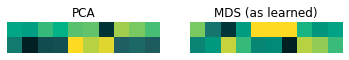

In [8]:
mds_matrix = pd_mds.model.weight.detach().numpy()

cmap = paradime.utils.plotting.get_colormap()
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(pca.components_[:2], cmap=cmap)
ax1.set_axis_off()
ax1.set_title("PCA")
ax2.imshow(mds_matrix, cmap=cmap)
ax2.set_axis_off()
ax2.set_title("MDS (as learned)");

At first glance this does not look to good. However, remember that MDS only takes into acount pairwise distances. This means that the absolute location of points does not matter; they might mirrored along axes or rotated. If we perform a slight transformation to our MDS matrix, we can verify that it is indeed very similar to PCA. In this case, we just have to reverse the rows, but in other cases it might be necessary to multiply some or all rows by -1.

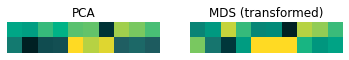

In [9]:
mds_matrix_tf = mds_matrix[::-1]

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(pca.components_[:2], cmap=cmap)
ax1.set_axis_off()
ax1.set_title("PCA")
ax2.imshow(mds_matrix_tf, cmap=cmap)
ax2.set_axis_off()
ax2.set_title("MDS (transformed)");

Finally, let's compare how the data points look under both tranformations.

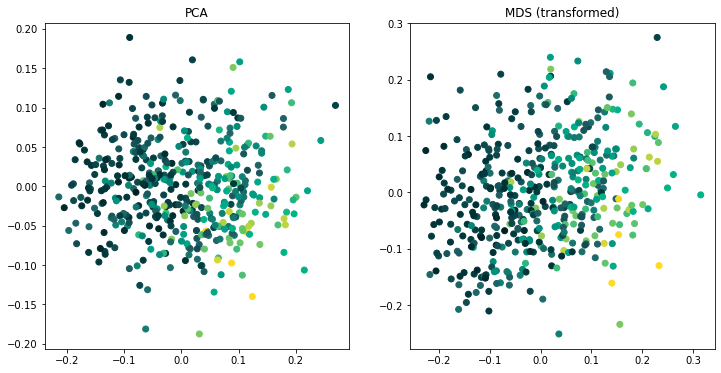

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.scatter(
    *np.stack([np.dot(pca.components_[:2], i) for i in data]).T,
    c=diabetes.target,
    cmap=cmap,
)
ax1.set_title("PCA")
ax2.scatter(
    *np.stack([np.dot(mds_matrix_tf, i) for i in data]).T,
    c=diabetes.target,
    cmap=cmap,
)
ax2.set_title("MDS (transformed)");


Also the scatterplots look pretty similar, especially with respect to the spatial distribution of target values (indicated by the color).

We can conclude that the parametric, linear MDS that we defined with paraDime actually did what it was supposed to do.

In [11]:
np.stack([np.dot(pca.components_[:2], i) for i in data]).T

array([[ 2.79306207e-02, -1.34686052e-01,  1.29447396e-02,
         2.34543980e-03, -3.59806910e-02, -1.88660280e-01,
        -9.48347610e-02,  9.87389258e-02,  2.86833351e-02,
        -1.00910711e-02, -1.83419418e-01,  1.88796730e-02,
        -7.59323171e-02,  1.51473512e-02, -8.01694940e-02,
         1.40488092e-01,  7.58600302e-03,  1.08839198e-01,
        -5.49947993e-02, -8.42651351e-02, -9.55955468e-02,
        -9.18719735e-02, -7.97268029e-02,  1.79486384e-01,
        -6.13394313e-02,  3.92363820e-03, -1.84828537e-01,
        -4.96967732e-02, -8.36788209e-02, -1.71885595e-02,
        -5.58611904e-02, -1.64968530e-01,  1.24056068e-01,
        -1.36513766e-01, -1.40162432e-01, -3.34396746e-02,
        -6.77447975e-03, -6.69444076e-02,  1.85191456e-01,
         7.28741657e-03,  1.15507838e-01, -1.74462889e-01,
        -2.76506311e-02, -8.56914170e-02,  9.67999958e-02,
        -1.01473230e-02, -1.15570589e-01, -1.61765051e-01,
        -4.07025090e-02,  6.12607134e-02, -4.92354907e-0